***IMPORTS***

In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import re
import string
import emoji

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [ ]:
nltk.download("punkt")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***LOADING THE DATASETS***

In [ ]:
# !kaggle datasets https://drive.google.com/file/d/1foE1JuZJeu5E_4qVge9kExzhvF32teuF/view
# !kaggle datasets download https://drive.google.com/file/d/13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75/view

# !gdown --id 1foE1JuZJeu5E_4qVge9kExzhvF32teuF
# !gdown --id 13IWXrTjGTrfCd9l7dScZVO8ZvMicPU75

In [ ]:
# Loading the trip advisor hotel reviews dataset into a dataframe

df_trip = pd.read_csv("/kaggle/input/ml4nlp-1-ex-02/tripadvisor_hotel_reviews.csv")

In [ ]:
# Loading the sci-fi dataset into a dataframe

with open(f'scifi.txt') as f:
    scifi_txt = f.read()

# Splitting the content into sentences using regex
sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', scifi_txt)

# Loading the sentences into a dataframe
df_scifi = pd.DataFrame(sentences, columns=['text'])

***EXPLORATORY DATA ANALYSIS (EDA)***

*Trip Advisor Hotel Reviews Data*

In [ ]:
# Info about the dataframe

df_trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
# First few rows of the dataframe

df_trip.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


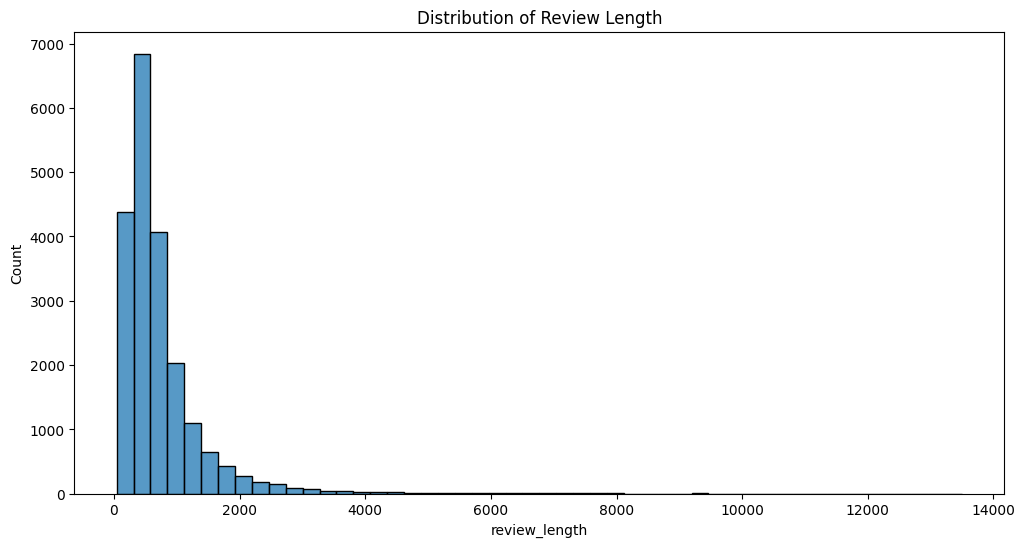

In [ ]:
# Visualizing the distribution of length of the reviews

df_trip['review_length'] = df_trip['Review'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df_trip['review_length'], bins=50)
plt.title('Distribution of Review Length')
plt.show()

In [ ]:
df_trip["review_length"].describe()

count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: review_length, dtype: float64

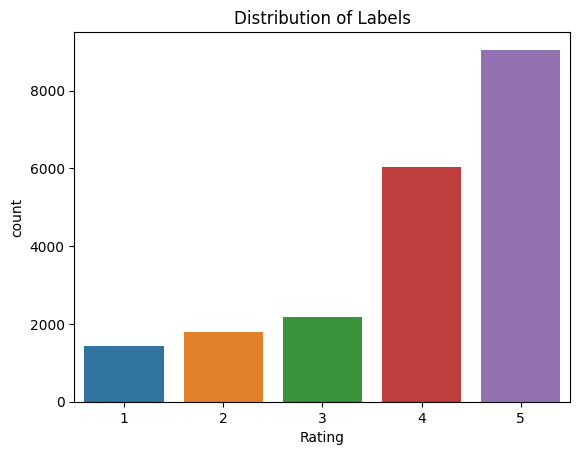

In [ ]:
# Distribution of Labels

sns.countplot(x='Rating', data=df_trip)
plt.title('Distribution of Labels')
plt.show()

In [ ]:
# Group by labels and describe review length statistics

print(df_trip.groupby('Rating')['review_length'].describe())

         count        mean         std   min     25%    50%      75%      max
Rating                                                                       
1       1421.0  769.534835  686.927121  77.0  351.00  564.0   943.00   6511.0
2       1793.0  867.002789  744.420751  74.0  433.00  653.0  1028.00   7802.0
3       2184.0  784.664835  743.864505  47.0  370.75  588.0   931.25  13501.0
4       6039.0  745.339957  729.579982  61.0  340.50  539.0   885.00  10062.0
5       9054.0  661.696488  627.032566  44.0  318.00  496.0   784.00  12738.0


*Sci-Fi Data*

In [ ]:
# Info about the dataset

df_scifi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105427 entries, 0 to 105426
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    105427 non-null  object
dtypes: object(1)
memory usage: 823.8+ KB


In [ ]:
# First few rows of the dataframe

df_scifi.head()

,text
0,MARCH # All Stories New and Complete Publisher...
1,"Volume #, No. #."
2,"Copyright # by Quinn Publishing Company, Inc."
3,Application for Entry' as Second Class matter ...
4,Subscription # for # issues in U.S. and Posses...


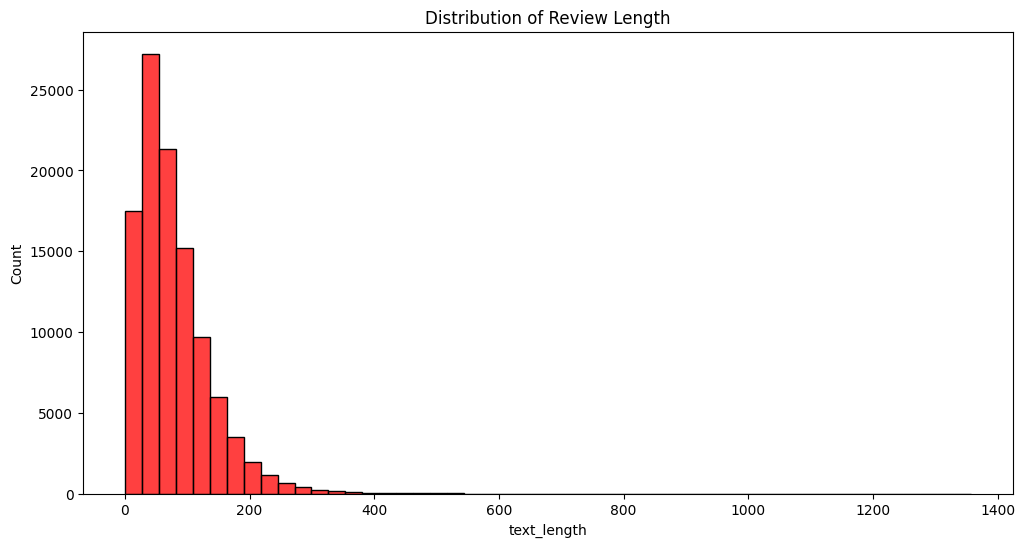

In [ ]:
# Visualizing the distribution of length of the reviews

df_scifi['text_length'] = df_scifi['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(df_scifi['text_length'], bins=50, color='red')
plt.title('Distribution of Review Length')
plt.show()

In [ ]:
df_scifi["text_length"].describe()

count    105427.000000
mean         78.567938
std          58.596386
min           1.000000
25%          37.000000
50%          65.000000
75%         105.000000
max        1357.000000
Name: text_length, dtype: float64

***DATA PREPROCESSING***

In [ ]:
def preprocess_review(review):
  # Convert all words to lower case
  review = review.lower()

  # Remove all punctuations
  review = review.translate(str.maketrans('', '', string.punctuation))

  # Remove all stop words
  # Tokenize the sentence
  tokens = nltk.word_tokenize(review)
  # Remove stop words
  clean_tokens = [token for token in tokens if not token.lower() in stop_words]
  # Join the tokens back into a sentence
  review = ' '.join(clean_tokens)

  # Removing HTML Tags, URLs and Website Links
  # Removing Website Links
  temp_text = review.split()

  for i in temp_text:
    if i[-4:] == ".com" or i[:4] == "www.":
      temp_text.remove(i)

  review = ' '.join(temp_text)

  # Remove HTML tags
  clean_text = re.sub('<[^<]+?>', '', review)

  # Remove URLs
  clean_text = re.sub(r'http\S+', '', clean_text)

  review = clean_text

  # Remove numbers
  review = re.sub(r'\d+', '', review)

  # Deemojize Emojis
  review = emoji.demojize(review)

  # Remove mentions
  review = re.sub(r'@\w+', '', review)

  # Stemming
  # Tokenize the sentence
  tokens = nltk.word_tokenize(review)

  # Stem the tokens
  stemmed_tokens = [stemmer.stem(token) for token in tokens]

  # Join the stemmed tokens back into a sentence
  review = ' '.join(stemmed_tokens)

  return review

***PREPROCESSING THE DATASETS***

*Trip Advisor Hotel Reviews Data*

In [ ]:
df_trip["Preprocessed Reviews"] = df_trip["Review"].apply(preprocess_review)

In [ ]:
cols = list(df_trip.columns.values)
cols

['Review', 'Rating', 'review_length', 'Preprocessed Reviews']

In [ ]:
df_trip = df_trip[['Review', 'Preprocessed Reviews', 'Rating', 'review_length']]

In [ ]:
df_trip.head()

,Review,Preprocessed Reviews,Rating,review_length
0,nice hotel expensive parking got good deal sta...,nice hotel expens park got good deal stay hote...,4,593
1,ok nothing special charge diamond member hilto...,ok noth special charg diamond member hilton de...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,nice room experi hotel monaco seattl good hote...,3,1427
3,"unique, great stay, wonderful time hotel monac...",uniqu great stay wonder time hotel monaco loca...,5,600
4,"great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...,5,1281


In [ ]:
# By deriving a set from `raw_text`, we deduplicate the array

raw_text = (' '.join(df_trip["Preprocessed Reviews"])).split()

In [ ]:
# We create our vocab, context words and target words

vocab = set(raw_text)
vocab_size = len(vocab)

*Scifi Data*

In [ ]:
df_scifi["preprocessed text"] = df_scifi["text"].apply(preprocess_review)

In [ ]:
df_scifi.head()

,text,text_length,preprocessed text
0,MARCH # All Stories New and Complete Publisher...,135,march stori new complet publish editor publish...
1,"Volume #, No. #.",16,volum
2,"Copyright # by Quinn Publishing Company, Inc.",45,copyright quinn publish compani inc
3,Application for Entry' as Second Class matter ...,89,applic entri second class matter post offic bu...
4,Subscription # for # issues in U.S. and Posses...,88,subscript issu us possess canada issu elsewher


In [ ]:
cols = list(df_scifi.columns.values)
cols

['text', 'text_length', 'preprocessed text']

In [ ]:
df_scifi = df_scifi[['text', 'preprocessed text', 'text_length']]

In [ ]:
df_scifi.head()

,text,preprocessed text,text_length
0,MARCH # All Stories New and Complete Publisher...,march stori new complet publish editor publish...,135
1,"Volume #, No. #.",volum,16
2,"Copyright # by Quinn Publishing Company, Inc.",copyright quinn publish compani inc,45
3,Application for Entry' as Second Class matter ...,applic entri second class matter post offic bu...,89
4,Subscription # for # issues in U.S. and Posses...,subscript issu us possess canada issu elsewher,88


In [ ]:
# By deriving a set from `raw_text_scifi`, we deduplicate the array

raw_text_scifi = (' '.join(df_scifi["preprocessed text"])).split()

In [ ]:
# We create our vocab for, context words and target words for scifi

vocab = set(raw_text_scifi)
vocab_size_scifi = len(vocab)

***INDEXING & VECTORIZING THE WORDS***

In [ ]:
# Index the words for trip advisor data

word_to_ix = {word: i for i, word in enumerate(vocab)}

In [ ]:
# Index the words for scifi data

word_to_ix_scifi = {word: i for i, word in enumerate(vocab)}

In [ ]:
# Define a function to make vectors of the context words

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

***DATALOADERS***

In [ ]:
class CBOWDataset(Dataset):

    def __init__(self, context_size, word_to_ix, raw_text=None, preprocessed_data=None):
        if preprocessed_data:
            self.data = preprocessed_data
        else:
            self.data = self._make_context_targets(context_size, raw_text)
        self.word_to_ix = word_to_ix

    def _make_context_targets(self, context_width, raw_text):
        data = []
        for i in range(context_width, len(raw_text) - context_width):
            # Using slicing to get the context words
            context = raw_text[i - context_width:i] + raw_text[i+1:i+1+context_width]
            target = raw_text[i]
            data.append((context, target))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context_words, target_word = self.data[idx]

        # Check if words are in word_to_ix and Convert list of context words to their indices
        context_idxs = torch.tensor([self.word_to_ix.get(w, 0) for w in context_words], dtype=torch.long)
        target_idx = torch.tensor(self.word_to_ix.get(target_word, 0), dtype=torch.long)

        return context_idxs, target_idx

***CBOW CLASS & MODEL***

In [ ]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, EMBEDDING_DIM, CONTEXT_WIDTH, HIDDEN_DIM, word_to_ix):
        super(CBOW, self).__init__()

        self.word_to_ix = word_to_ix

        # Embedding layer to represent words in a dense form
        self.embeddings = nn.Embedding(vocab_size, EMBEDDING_DIM)

        # The input to this layer is CONTEXT_WIDTH words from the left, and CONTEXT_WIDTH from the right.
        # Each word is represented as an EMBEDDING_DIM sized vector.
        self.linear1 = nn.Linear(CONTEXT_WIDTH * 2 * EMBEDDING_DIM, HIDDEN_DIM)

        # An additional hidden layer for better representation
        self.linear2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.linear3 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.linear4 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)

        # The output layer predicts the central word, so it has vocab_size units
        self.linear5 = nn.Linear(HIDDEN_DIM, vocab_size)

    def forward(self, context_idxs):
        # Embed the words
        embeds = self.embeddings(context_idxs)

        # Flatten the embeddings
        embeds = embeds.view(-1, embeds.size(1) * embeds.size(2))

        # Pass through the layers
        out = F.relu(self.linear1(embeds))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = F.relu(self.linear4(out))
        out = self.linear5(out)

        # Predict the log probabilities of the center word
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

    def train_model(self, epochs, optimizer, train_dataloader, val_dataloader, device):
        loss_function = nn.NLLLoss()
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            self.train()
            total_loss = 0

            # Training loop with progress bar
            pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
            for context_idxs, target_idx in pbar:
                context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
                self.zero_grad()
                log_probs = self(context_idxs)
                loss = loss_function(log_probs, target_idx)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Update the progress bar description
                pbar.set_description(f"Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f}")


            train_losses.append(total_loss/len(train_dataloader))
            print(f"\nEpoch {epoch+1}, Training Loss: {total_loss/len(train_dataloader)}")

            self.eval()
            total_val_loss = 0

            # Validation loop with progress bar
            val_pbar = tqdm(val_dataloader, desc=f"Validating Epoch {epoch+1}/{epochs}")
            with torch.no_grad():
                for context_idxs, target_idx in val_pbar:
                    context_idxs, target_idx = context_idxs.to(device), target_idx.to(device)
                    log_probs = self(context_idxs)
                    loss = loss_function(log_probs, target_idx)
                    total_val_loss += loss.item()

                    # Update the validation progress bar description
                    val_pbar.set_description(f"Validating Epoch {epoch+1}/{epochs} Val Loss: {loss.item():.4f}")

            val_losses.append(total_val_loss/len(val_dataloader))
            print(f"Epoch {epoch+1}, Validation Loss: {total_val_loss/len(val_dataloader)}")
        return train_losses, val_losses

In [ ]:
# Setting hyperparameters for trip advisor data model CBOW2

EMBEDDING_DIM = 50
CONTEXT_WIDTH = 2
HIDDEN_DIM = 256
N_EPOCHS = 12

*Initializing the dataloader for the trip advisor dataset CBOW2*

In [ ]:
# Create the full dataset using the raw text
full_dataset = CBOWDataset(CONTEXT_WIDTH, word_to_ix, raw_text=raw_text)

# Split the dataset into training, validation, and test sets
train_data, temp_data = train_test_split(full_dataset.data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Using the split data to instantiate datasets
# raw_text is defaulted to None when using preprocessed_data
train_dataset = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix, preprocessed_data=train_data)
val_dataset = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix, preprocessed_data=val_data)
test_dataset = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix, preprocessed_data=test_data)

# Creating dataloaders for each dataset
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

*Training the model for trip advisor dataset CBOW2*

In [ ]:
# Initialize training

model_cbow2_trip = CBOW(vocab_size, EMBEDDING_DIM, CONTEXT_WIDTH, HIDDEN_DIM, word_to_ix)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cbow2_trip.to(device)

optimizer = torch.optim.Adam(model_cbow2_trip.parameters(), lr=0.001)
loss_function = nn.NLLLoss()

train_losses, val_losses = model_cbow2_trip.train_model(N_EPOCHS, optimizer, train_dataloader, val_dataloader, device)

Epoch 1/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 1, Training Loss: 7.327167549993736


Validating Epoch 1/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 1, Validation Loss: 7.199775375889701


Epoch 2/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 2, Training Loss: 7.076125635845895


Validating Epoch 2/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 2, Validation Loss: 7.131687975747764


Epoch 3/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 3, Training Loss: 6.9808587543012495


Validating Epoch 3/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 3, Validation Loss: 7.085834703421199


Epoch 4/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 4, Training Loss: 6.922074271142175


Validating Epoch 4/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 4, Validation Loss: 7.0556755730884655


Epoch 5/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 5, Training Loss: 6.877052584535957


Validating Epoch 5/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 5, Validation Loss: 7.028995743397685


Epoch 6/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 6, Training Loss: 6.841585553428063


Validating Epoch 6/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 6, Validation Loss: 7.010823047903321


Epoch 7/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 7, Training Loss: 6.8131261895736985


Validating Epoch 7/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 7, Validation Loss: 7.00321435095243


Epoch 8/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 8, Training Loss: 6.7745549946741725


Validating Epoch 8/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 8, Validation Loss: 6.946895168727356


Epoch 9/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 9, Training Loss: 6.734728101721712


Validating Epoch 9/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 9, Validation Loss: 6.941313672247502


Epoch 10/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 10, Training Loss: 6.709710677635224


Validating Epoch 10/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 10, Validation Loss: 6.936423045555851


Epoch 11/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 11, Training Loss: 6.691229186097051


Validating Epoch 11/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 11, Validation Loss: 6.937813163106596


Epoch 12/12:   0%|          | 0/25182 [00:00<?, ?it/s]


Epoch 12, Training Loss: 6.6845261707136245


Validating Epoch 12/12:   0%|          | 0/3148 [00:00<?, ?it/s]

Epoch 12, Validation Loss: 6.952419428237663


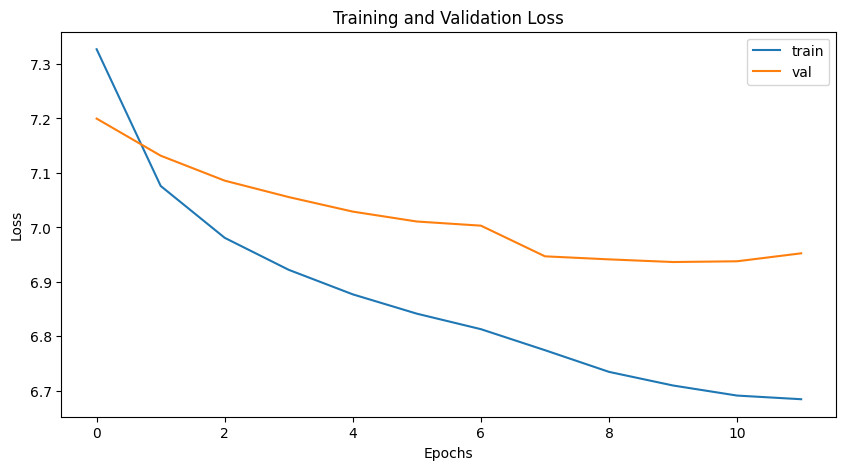

In [ ]:
# After training
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def test_model_cbow2_trip(self, test_dataloader):
    self.eval()
    total_loss = 0
    loss_function = nn.NLLLoss()

    test_pbar = tqdm(test_dataloader, desc="Testing")
    with torch.no_grad():
        for context, target in test_pbar:
            context, target = context.to(device), target.to(device)
            log_probs = self(context)
            loss = loss_function(log_probs, target)
            total_loss += loss.item()

            test_pbar.set_description(f"Testing Loss: {loss.item():.4f}")

    avg_test_loss = total_loss / len(test_dataloader)
    print(f"Average Testing Loss: {avg_test_loss}")
    return avg_test_loss

# Run the test
test_model_cbow2_trip(model_cbow2_trip, test_dataloader)

Testing:   0%|          | 0/3148 [00:00<?, ?it/s]

Average Testing Loss: 6.940714779621159


6.940714779621159

In [ ]:
# Reverse dictionary of word_to_ix
index_to_word = {index: word for word, index in word_to_ix.items()}

***DEFINE NECESSARY FUNCTIONS TO GET THE CLOSEST VECTORS/WORDS***

In [ ]:
def get_closest_word(word, net, topn=5):
    word_distance = []
    emb = net.embeddings
    pdist = nn.PairwiseDistance()
    i = word_to_ix[word]
    lookup_tensor_i = torch.tensor([i], dtype=torch.long).to(device)
    v_i = emb(lookup_tensor_i)
    for j in range(len(vocab)):
        if j != i:
            lookup_tensor_j = torch.tensor([j], dtype=torch.long).to(device)
            v_j = emb(lookup_tensor_j)
            word_distance.append((index_to_word[j], float(pdist(v_i, v_j))))
    word_distance.sort(key=lambda x: x[1])
    return word_distance[:topn]

In [ ]:
def print_closest_words(query_word, net):
    closest_tuples = get_closest_word(query_word, net)
    closest_words = [word[0] for word in closest_tuples]  # Extract words from the tuples
    print(f'The five closest words to "{query_word}" are: {", ".join(closest_words)}')

*5 CLOSEST VECTORS/WORDS FOR TRIP ADVISOR DATA CBOW2*

In [ ]:
net = model_cbow2_trip

In [ ]:
print_closest_words("hotel", model_cbow2_trip)
print_closest_words("room", model_cbow2_trip)
print_closest_words("staff", model_cbow2_trip)

The five closest words to "hotel" are: properti, resort, westin, nonsstop, altamont
The five closest words to "room" are: stationperfect, unmemor, rom, popluar, dramat
The five closest words to "staff" are: employe, greet, concierg, receptionist, childreninf


In [ ]:
print_closest_words("beautiful", model_cbow2_trip))
print_closest_words("larg", model_cbow2_trip))
print_closest_words("pleasant", model_cbow2_trip))

The five closest words to "beautiful" are: pricey, nice, love, bathroomi, chioc
The five closest words to "larg" are: small, bathroomi, ammen, kept, adequ
The five closest words to "pleasant" are: nice, encount, wonder, courtiou, serious


In [ ]:
print_closest_words("decorat", model_cbow2_trip))
print_closest_words("book", model_cbow2_trip))
print_closest_words("check", model_cbow2_trip))

The five closest words to "decorat" are: downsid, cofe, typic, improvestaff, seemsto
The five closest words to "book" are: arriv, stay, suggest, visit, went
The five closest words to "check" are: arriv, problem, hrperson, inform, mealther


In [ ]:
# Setting hyperparameters for scifi data model CBOW2

EMBEDDING_DIM = 50
CONTEXT_WIDTH = 2
HIDDEN_DIM = 256
N_EPOCHS = 3

*Initializing the dataloader for the trip advisor dataset CBOW2*

In [ ]:
# Create the full dataset using the raw text
full_dataset_scifi = CBOWDataset(CONTEXT_WIDTH, word_to_ix_scifi, raw_text=raw_text_scifi)

# Split the dataset into training, validation, and test sets
train_data_scifi, temp_data_scifi = train_test_split(full_dataset_scifi.data, test_size=0.2, random_state=42)
val_data_scifi, test_data_scifi = train_test_split(temp_data_scifi, test_size=0.5, random_state=42)

# Using the split data to instantiate datasets
# raw_text is defaulted to None when using preprocessed_data
train_dataset_scifi = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix_scifi, preprocessed_data=train_data_scifi)
val_dataset_scifi = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix_scifi, preprocessed_data=val_data_scifi)
test_dataset_scifi = CBOWDataset(context_size=CONTEXT_WIDTH, word_to_ix=word_to_ix_scifi, preprocessed_data=test_data_scifi)

# Creating dataloaders for each dataset
train_dataloader_scifi = DataLoader(train_dataset_scifi, batch_size=64, shuffle=True, num_workers=4)
val_dataloader_scifi = DataLoader(val_dataset_scifi, batch_size=64, shuffle=False, num_workers=4)
test_dataloader_scifi = DataLoader(test_dataset_scifi, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


*Training the model for scifi dataset CBOW2*

In [ ]:
# Initialize training

model_cbow2_scifi = CBOW(vocab_size_scifi, EMBEDDING_DIM, CONTEXT_WIDTH, HIDDEN_DIM, word_to_ix_scifi)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
model_cbow2_scifi.to(device)

optimizer = torch.optim.Adam(model_cbow2_scifi.parameters(), lr=0.001)
loss_function = nn.NLLLoss()

train_losses_scifi, val_losses_scifi = model_cbow2_scifi.train_model(N_EPOCHS, optimizer, train_dataloader_scifi, val_dataloader_scifi, device)

Epoch 1/3:   0%|          | 0/9623 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Epoch 1, Training Loss: 8.230322766326314


Validating Epoch 1/3:   0%|          | 0/1203 [00:00<?, ?it/s]

Epoch 1, Validation Loss: 8.17569234821069


Epoch 2/3:   0%|          | 0/9623 [00:00<?, ?it/s]


Epoch 2, Training Loss: 8.068708889897916


Validating Epoch 2/3:   0%|          | 0/1203 [00:00<?, ?it/s]

Epoch 2, Validation Loss: 8.209749196037489


Epoch 3/3:   0%|          | 0/9623 [00:00<?, ?it/s]


Epoch 3, Training Loss: 7.989269685809656


Validating Epoch 3/3:   0%|          | 0/1203 [00:00<?, ?it/s]

Epoch 3, Validation Loss: 8.223068707007124


In [ ]:
index_to_word = {index: word for word, index in word_to_ix_scifi.items()}
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [ ]:
print_closest_words("time", model_cbow2_scifi)
print_closest_words("planet", model_cbow2_scifi)
print_closest_words("slope", model_cbow2_scifi)

The five closest words to "time" are: dowm, voliin, cooki, nr, winter
The five closest words to "planet" are: haphazard, posabilit, nitwit, ote, puhli
The five closest words to "slope" are: dsked, gailydress, doubl, uppiti, supersecreci


In [ ]:
print_closest_words("old", model_cbow2_scifi)
print_closest_words("long", model_cbow2_scifi)
print_closest_words("rich", model_cbow2_scifi)

The five closest words to "old" are: medivim, circuit, conjug, goof, ultrafax
The five closest words to "long" are: waterloo, centerpoint, musd, left, deme
The five closest words to "rich" are: bluish, protrud, viewer, transform, tamiskefl


In [ ]:
print_closest_words("said", model_cbow2_scifi)
print_closest_words("cant", model_cbow2_scifi)
print_closest_words("scare", model_cbow2_scifi)

The five closest words to "said" are: refashion, huh, dutyfre, stf, ummm
The five closest words to "cant" are: drastic, custodi, professioo, dumb, noroton
The five closest words to "scare" are: likclv, tember, descript, sam, barl


In [ ]:
print_closest_words("time", model_cbow2_trip)
print_closest_words("cant", model_cbow2_trip)

NameError: ignored